In [94]:
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

In [99]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

    # Calculate duration
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

    # in seconds
    df['duration'] = df['duration'].dt.total_seconds() / 60

    # durations for more than 1 minute and less than 60 minutes
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

    categorical = ['PULocationID', 'DOLocationID']

    df[categorical] = df[categorical].astype(str)
    
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    
    return df

In [100]:
train_df = read_dataframe("./green_tripdata_2024-01.parquet")
test_df = read_dataframe("./green_tripdata_2024-02.parquet")

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

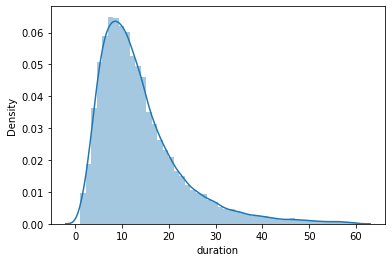

In [73]:
sns.distplot(df_train['duration'])

In [101]:
categorical = ['PU_DO']#['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

train_dict = train_df[categorical + numerical].to_dict(orient="records")
val_dicts = test_df[categorical + numerical].to_dict(orient="records")

dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = train_df[target].values
y_val = test_df[target].values

In [102]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_pred = lr_model.predict(X_val)

print("train: ", mean_squared_error(y_train, y_train_pred, squared=False))
print("test: ", mean_squared_error(y_val, y_pred, squared=False))

train:  4.652850237786116
test:  5.98265006818705


In [103]:
lr_model = Lasso()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_pred = lr_model.predict(X_val)

print("train: ", mean_squared_error(y_train, y_train_pred, squared=False))
print("test: ", mean_squared_error(y_val, y_pred, squared=False))

train:  9.019532867192334
test:  9.110340896856446


In [104]:
lr_model = Ridge()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_pred = lr_model.predict(X_val)

print("train: ", mean_squared_error(y_train, y_train_pred, squared=False))
print("test: ", mean_squared_error(y_val, y_pred, squared=False))

train:  7.929757988246295
test:  8.03695949587832


In [109]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_val)

print("train: ", mean_squared_error(y_train, y_train_pred, squared=False))
print("test: ", mean_squared_error(y_val, y_pred, squared=False))

train:  5.063927633534167
test:  5.365642179025046


In [111]:
with open('models/xgb_model.bin', 'wb') as f_out:
    pickle.dump((dv, xgb_model), f_out)